In [15]:
import requests

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "licensed-child-care-centres"}
package = requests.get(url, params = params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):

       # for datastore_active resources:
       if resource["datastore_active"]:

           # To get all records in CSV format:
           url = base_url + "/datastore/dump/" + resource["id"]
           resource_dump_data = requests.get(url).text
           print(resource_dump_data)

           # To selectively pull records and attribute-level metadata:
           url = base_url + "/api/3/action/datastore_search"
           p = { "id": resource["id"] }
           resource_search_data = requests.get(url, params = p).json()["result"]
           print(resource_search_data)
           # This API call has many parameters. They're documented here:
           # https://docs.ckan.org/en/latest/maintaining/datastore.html

       # To get metadata for non datastore_active resources:
       if not resource["datastore_active"]:
           url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
           resource_metadata = requests.get(url).json()
           print(resource_metadata)
           # From here, you can use the "url" attribute to download this file

_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,cwelcc_flag,geometry
1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,31JUL24,Y,"{""type"": ""Point"", ""coordinates"": [-79.50419384, 43.59992437]}"
2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,31JUL24,Y,"{""type"": ""Point"", ""coordinates"": [-79.42037489, 43.705765578]}"
3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,31JUL24,Y,"{""type"": ""Point"", ""coordinates"": [-79.175461625, 43.793287951]}"
4,1016,George Brown - Richmond Adelaide Childcare

In [16]:
!pip install pandas matplotlib seaborn
!pip install folium geopy ipywidgets
!pip install folium
!pip install geopy
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import ipywidgets as widgets
from IPython.display import display, IFrame
from ipywidgets import interact

In [17]:
# Find the CSV resource in the package
csv_resource = next((res for res in package["result"]["resources"] if res["format"].lower() == "csv"), None)
if not csv_resource:
    raise ValueError("CSV resource not found in the package")

In [18]:
# Download the CSV data
csv_url = csv_resource["url"]
df = pd.read_csv(csv_url)

In [19]:
# Display the first few rows of the dataset
print(df.head())

   _id  LOC_ID                                           LOC_NAME  \
0    1    1013              Lakeshore Community Child Care Centre   
1    2    1014            Alternative Primary School Parent Group   
2    3    1015     Cardinal Leger Child Care Centre (Scarborough)   
3    4    1016  George Brown - Richmond Adelaide Childcare Centre   
4    5    1017  Woodland Nursery School (Warden Woods Communit...   

             AUSPICE            ADDRESS    PCODE  ward               PHONE  \
0  Non Profit Agency     101 SEVENTH ST  M8V 3B5     3      (416) 394-7601   
1  Non Profit Agency    1100 SPADINA RD  M5N 2M6     8      (416) 322-5385   
2  Non Profit Agency     600 MORRISH RD  M1C 4Y1    25      (416) 287-0578   
3  Non Profit Agency  130 ADELAIDE ST W  M5H 3P5    10      (416) 415-2453   
4  Non Profit Agency    1 FIRVALLEY CRT  M1L 1N8    20  (416) 694-1138x163   

                    bldg_type                         BLDGNAME  IGSPACE  \
0    Public Elementary School     Seventh

In [20]:
# Display the first few rows of the DataFrame
df.head()

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,cwelcc_flag,geometry
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,31JUL24,Y,"{'type': 'MultiPoint', 'coordinates': [[-79.50..."
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,31JUL24,Y,"{'type': 'MultiPoint', 'coordinates': [[-79.42..."
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,31JUL24,Y,"{'type': 'MultiPoint', 'coordinates': [[-79.17..."
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,(416) 415-2453,Other,NaN,10,15,40,0,0,65,Y,31JUL24,Y,"{'type': 'MultiPoint', 'coordinates': [[-79.38..."
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,(416) 694-1138x163,High Rise Apartment,NaN,0,10,16,0,0,26,Y,31JUL24,Y,"{'type': 'MultiPoint', 'coordinates': [[-79.28..."


C:\Users\yulii\AppData\Local\Temp\ipykernel_32208\3071230457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TOTSPACE', y='LOC_NAME', data=df.sort_values(by='TOTSPACE', ascending=False).head(20), palette='viridis')


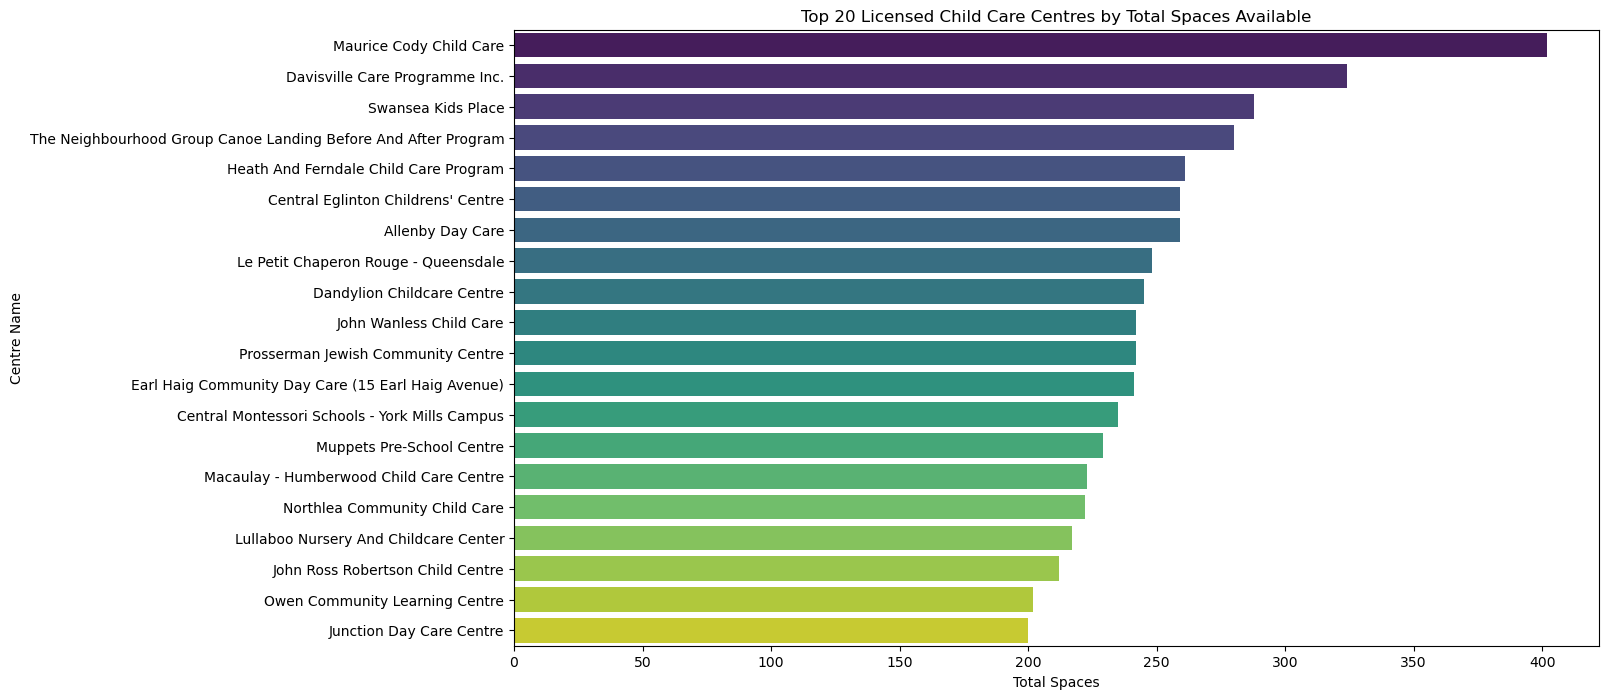

In [22]:
# Plot total spaces available in each centre
plt.figure(figsize=(14, 8))
sns.barplot(x='TOTSPACE', y='LOC_NAME', data=df.sort_values(by='TOTSPACE', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Licensed Child Care Centres by Total Spaces Available')
plt.xlabel('Total Spaces')
plt.ylabel('Centre Name')
plt.show()

In [25]:
# Function to get coordinates using geopy
def get_coordinates(address):
    geolocator = Nominatim(user_agent="child_care_map")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    try:
        location = geocode(address)
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except Exception as e:
        print(f"Error getting coordinates for address '{address}': {e}")
        return (None, None)

# Check if ADDRESS column exists
if 'ADDRESS' not in df.columns:
    raise ValueError("ADDRESS column is missing in the DataFrame")

# Apply the function to get coordinates for each address
df[['latitude', 'longitude']] = df['ADDRESS'].apply(get_coordinates).apply(pd.Series)

# Drop rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])

# Create a folium map centered around Toronto
m = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# Add markers for each child care center
for idx, row in df.iterrows():
    color = 'blue' if row['subsidy'] == 'Y' else 'yellow'
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['LOC_NAME']} ({row['AUSPICE']})\n{row['ADDRESS']}",
        tooltip=row['LOC_NAME'],
        icon=folium.Icon(color=color)
    ).add_to(m)

# Display the map in a Jupyter notebook (if running in a notebook environment)
m

RateLimiter caught an error, retrying (0/2 tries). Called with (*('101 SEVENTH ST',), **{}).
Traceback (most recent call last):
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\site-packages\urllib3\connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\site-packages\urllib3\connection.py", line 464, in getresponse
    httplib_response = super().getresponse()
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\http\client.py", line 1377, in getresponse
    response.begin()
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\http\client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\http\client.py", line 281, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\yulii\soft\miniconda3\envs\dsi_participant\lib\socket.py", line 704, i